In [1]:
!git clone https://github.com/nipponjo/deepfillv2-pytorch.git

Cloning into 'deepfillv2-pytorch'...



In [11]:
# %pip install easyocr
# %pip install numba
# %pip install gdown

In [12]:
import pandas as pd
import easyocr as eo
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import gc
import torch
from numba import cuda
from PIL import Image, ImageOps
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import gdown
from tqdm import tqdm 
import torchvision.transforms as T

In [13]:
%pwd

'/teamspace/studios/this_studio'

In [14]:
import sys
sys.path.append('/teamspace/studios/this_studio/deepfillv2-pytorch')

from model.networks import Generator

## Extracting the text mask

This step will help to determine which part of the meme to generate using inpainting

The images will also be resized using padding to ensure that no information is lost.

In [15]:
def process_image_and_mask(image_path, target_size=512, languages=['en'], gpu=True):
    reader = eo.Reader(languages, gpu=gpu)
    image = cv2.imread(image_path)

    results = reader.readtext(image_path)

    height, width, _ = image.shape
    binary_mask = np.zeros((height, width), dtype=np.uint8)

    for result in results:
        bbox, text, score = result
        l_bbox, l_bbox1 = bbox[0]
        r_bbox, r_bbox1 = bbox[2]

        cv2.rectangle(binary_mask, 
                      (int(l_bbox), int(l_bbox1)), 
                      (int(r_bbox), int(r_bbox1)), 
                      255, -1)

    return image, binary_mask

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

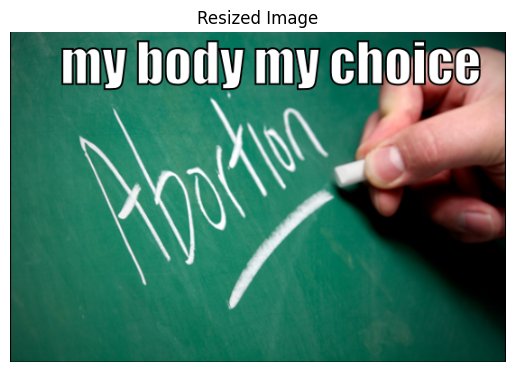

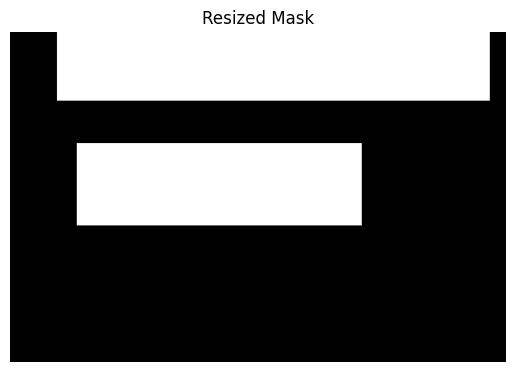

In [16]:
image_path = "./final_dataset/01382_e324252c-acd6-4996-8c81-d3fec4c2748b.png"
image, b_mask = process_image_and_mask(image_path, target_size=512, languages=['en'], gpu=True)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Resized Image")
plt.axis('off')
plt.show()

# Display resized mask
plt.imshow(b_mask, cmap='gray')
plt.title("Resized Mask")
plt.axis('off')
plt.show()

## Using DeepFilv2

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
sd_path = './deepfillv2-pytorch/pretrained/'
gdown.download('https://drive.google.com/u/0/uc?id=1L63oBNVgz7xSb_3hGbUdkYW1IuRgMkCa', output=sd_path, quiet=False)
sd_path = './deepfillv2-pytorch/pretrained/states_pt_places2.pth'

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1L63oBNVgz7xSb_3hGbUdkYW1IuRgMkCa
From (redirected): https://drive.google.com/uc?id=1L63oBNVgz7xSb_3hGbUdkYW1IuRgMkCa&confirm=t&uuid=f65c793c-e76f-44e9-a3b9-fa6a5fcd09ce
To: /teamspace/studios/this_studio/deepfillv2-pytorch/pretrained/states_pt_places2.pth
100%|██████████| 120M/120M [00:00<00:00, 120MB/s]  


In [20]:
generator = Generator(checkpoint=sd_path, return_flow=True).to(device)

## Inpainting with meme example

In [21]:
image = T.ToTensor()(image).to(device)
b_mask = T.ToTensor()(b_mask).to(device)

output = generator.infer(image, b_mask, return_vals=['inpainted', 'stage1', 'stage2', 'flow'])

Result:


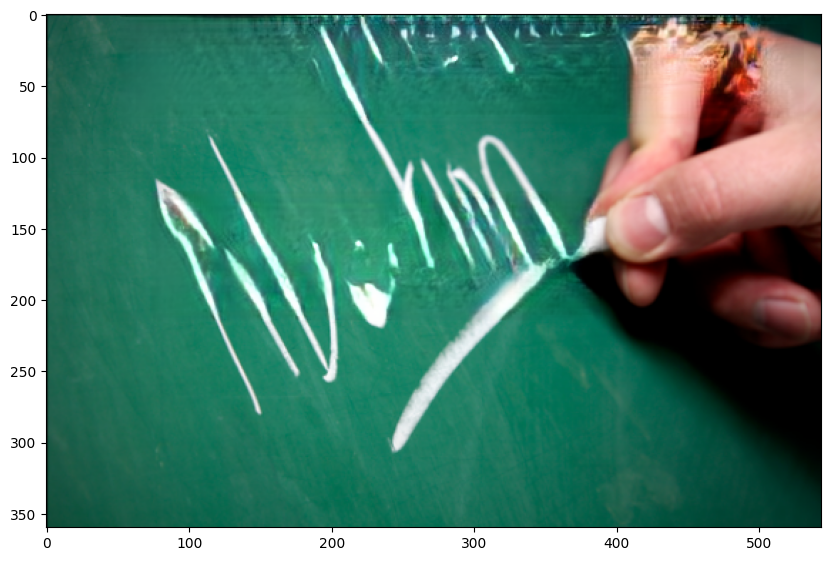

In [22]:
print("Result:")
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output[0], cv2.COLOR_BGR2RGB))
plt.show()

## Resizing all the images

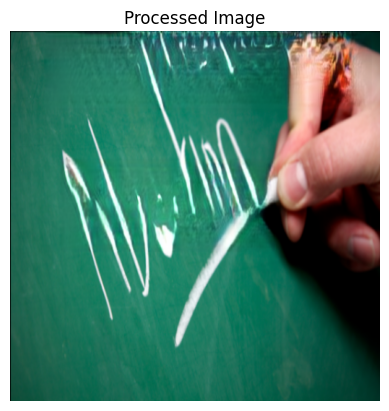

In [23]:
def resize_and_center_crop(image, target_min=300, target_max=512, target_size=512):
    height, width, _ = image.shape
    
    aspect_ratio = width / height

    # Step 1: Resize with Padding if the image is smaller than target_min
    if width < target_min or height < target_min:
        pad_width = max(target_min - width, 0)
        pad_height = max(target_min - height, 0)
        
        padded_image = cv2.copyMakeBorder(
            image, 
            0, pad_height, 0, pad_width, 
            cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )
        # Resize to target_max size if padded
        image = cv2.resize(padded_image, (target_max, target_max))

    # Step 2: Resize the image if it exceeds target_max while maintaining aspect ratio
    height, width, _ = image.shape
    if width > target_max or height > target_max:
        if width > height:
            scale_factor = target_max / width
        else:
            scale_factor = target_max / height

        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        
        image = cv2.resize(image, (new_width, new_height))
    
    # Step 3: Center Crop to target_size if necessary
    height, width, _ = image.shape
    center_x, center_y = width // 2, height // 2
    
    # Calculate the cropping box
    crop_x1 = max(center_x - target_size // 2, 0)
    crop_x2 = min(center_x + target_size // 2, width)
    crop_y1 = max(center_y - target_size // 2, 0)
    crop_y2 = min(center_y + target_size // 2, height)
    
    cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]
    
    # Resize the cropped image to the target size (if necessary)
    if cropped_image.shape[0] != target_size or cropped_image.shape[1] != target_size:
        cropped_image = cv2.resize(cropped_image, (target_size, target_size))
    
    return cropped_image

# Example usage
processed_image = resize_and_center_crop(output[0], target_min=300, target_max=512, target_size=512)

# Display the processed image
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.title("Processed Image")
plt.axis('off')
plt.show()

## Combining everything into a pipeline

In [32]:
def inpainting_pipeline(image_path, directory='./final_dataset_inpainted'): 
    image, b_mask = process_image_and_mask(image_path, target_size=512, languages=['en'], gpu=True)
    image = T.ToTensor()(image).to(device)
    b_mask = T.ToTensor()(b_mask).to(device)

    output = generator.infer(image, b_mask, return_vals=['inpainted', 'stage1', 'stage2', 'flow'])

    processed_image = resize_and_center_crop(output[0], target_min=300, target_max=512, target_size=512)
    # free_gpu_cache()   
    cudaDeviceReset()

    output_path = os.path.join(directory, image_path)
    cv2.imwrite(output_path, processed_image)

    return processed_image

In [33]:
output_directory = './final_dataset_inpainted'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [34]:
df = pd.read_csv("./final_dataset.csv")
df.head(3)

,image_path,label,meme_text,file_extension,language_code,sentence_length,average_word_length,hashtags_count,emails_count,numbers_count,usernames_count,websites,pos_tags,named_entities,new_image_path,meme_text_masked
0,./dataset/violence against women meme offensiv...,1,When mom takes away my fidget spinner.,jpg,Language.ENGLISH,7,4.571429,0,0,0,0,[],"['SCONJ', 'NOUN', 'VERB', 'ADV', 'PRON', 'NOUN...",[],final_dataset/Image_15_0d42f67a-74dd-4415-b286...,When mom takes away my fidget spinner.
1,./dataset/violence against women meme offensiv...,1,Morning wood? You mean my wife's alarm clock.,jpg,Language.ENGLISH,8,4.750000,0,0,0,0,[],"['NOUN', 'NOUN', 'PUNCT', 'PRON', 'VERB', 'PRO...",[],final_dataset/Image_14_255b3022-61df-4e4e-93d0...,Morning wood? You mean my wife's alarm clock.
2,./dataset/violence against women meme offensiv...,1,When captain man calls you to the man cave at ...,jpg,Language.ENGLISH,23,3.956522,0,0,0,0,[],"['SCONJ', 'NOUN', 'NOUN', 'VERB', 'PRON', 'ADP...",['TIME'],final_dataset/Image_16_fa940fca-ef00-4425-851e...,When captain man calls you to the man cave at ...


In [35]:
def free_gpu_cache():                         
    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

In [ ]:
def apply_inpainting_on_dataframe(df):
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        image_path = row['new_image_path']
        processed_image = inpainting_pipeline(image_path)
        output_path = os.path.join('./final_dataset_inpainted', os.path.basename(image_path))
        cv2.imwrite(output_path, processed_image)
        df.at[idx, 'processed_image_path'] = output_path
        free_gpu_cache()
        print(f"finished {idx}")

    return df

df_with_inpainting = apply_inpainting_on_dataframe(df)
df_with_inpainting.to_csv('/kaggle/working/final_dataset_inpainted_with_paths.csv', index=False)

  0%|          | 0/9755 [00:00<?, ?it/s]

In [37]:
TORCH_USE_CUDA_DSA=1

In [1]:
df

NameError: name 'df' is not defined